In [7]:
# Import libraries
import boto3
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib
from io import BytesIO, StringIO
from datetime import datetime, timezone, date
import geopandas as gpd
import contextily as cx
import seaborn as sns

In [8]:
# Function: iterate through raw folder and get all station lists (with )
def get_station_list_paths(bucket_name, directory):
    # Set up variables
    s3 = boto3.resource("s3")
    s3_cl = boto3.client('s3') # for lower-level processes
    get_last_modified = lambda obj: int(obj['LastModified'].strftime('%s')) #  Write method to get last modified file

    # Read in all station lists.
    # Get list of folder prefixes
    response = s3_cl.list_objects_v2(Bucket=bucket_name, Prefix = directory, Delimiter = '/')

    networks = {'Network':[], 'NetworkPath':[], 'StationFile':[]}

    for prefix in response['CommonPrefixes']: # For each folder path
        networkpath = prefix['Prefix'][:-1]
        networkname = networkpath.split("/")[-1]
        station_file = s3.Bucket(bucket_name).objects.filter(Prefix = networkpath+"/"+"stationlist_").all()
        if len(list(station_file))==1: # If one item returned
            for item in station_file: # Get station file
                networks['Network'].append(networkname)
                networks['NetworkPath'].append(networkpath)
                networks['StationFile'].append(item.key)
                break # If more than one file of this format found in folder, just take the most recent.
        elif len(list(station_file))==0: # If no items found using search above
            files = s3.Bucket(bucket_name).objects.filter(Prefix = networkpath+"/") # List all files in folder
            file = [file for file in files if "station" in file.key] # More general search for 'station'
            for item in file: # Keep all files found here. These files may be different (e.g. ISD ASOS/AWOS vs ASOS/AWOS station lists)
                networks['Network'].append(networkname)
                networks['NetworkPath'].append(networkpath)
                networks['StationFile'].append(item.key)
        elif len(list(station_file))>1: # If more than one identically formatted station list returned (shouldn't happen), take most recent
            file = [obj.key for obj in sorted(station_file, key=lambda x: x.last_modified, reverse=True)] # Sort station files by most recent edit
            networks['Network'].append(networkname)
            networks['NetworkPath'].append(networkpath)
            networks['StationFile'].append(file[0]) # Add path to most recently changed file. (Tested and works)
        # Note method currently doesn't have a method for dealing with more than one normally formatted station file 
    return networks        

def get_station_list(bucket_name, directory):
    # Set up variables
    s3 = boto3.resource("s3") # Note these calls are reproduced in get_station_list_paths, but this enables us to run that function separately.
    s3_cl = boto3.client('s3') # for lower-level processes
    dffull = pd.DataFrame()
    
    networks = get_station_list_paths(bucket_name, directory)
    networks = pd.DataFrame(networks)
    
    # Remove ASOS/AWOS, madis and isd lists to prevent duplicates
    # note: for station masterlist, you'll probably want to KEEP the asosawos_stations and remove isd_asosawos or merge both!
    # we do this here because the ISD station list has start/end dates, and asosawos does not.
    # If station has more than one type of station file (e.g. ASOSAWOS), manually remove the one you don't want to use here.
    remove_list = ['/stationlist_ASOSAWOS.csv', '/isd_stations.csv', 'madis_stations.csv'] # / used to keep otherisd_stations.csv
    networks = networks[~networks.StationFile.str.contains('|'.join(remove_list))]

    # Check that no network has >1 station file and break code if it does.
    boolean = networks["Network"].is_unique

    total = 0 

    #print(boolean)
    if boolean is False: # Tested by commenting out two remove lines above, works.
        dupes = networks['Network'].duplicated()
        doubles = list(networks['Network'][dupes])
        print("Error: More than one station file found for the following networks: {}. Inspect folder, add duplicated files to remove_list and re-run function.".format(doubles))   
        return
    
    for index, row in networks.iterrows():
        try:
            #print(row['StationFile'])
            # Get data
            df = pd.DataFrame()
            obj = s3_cl.get_object(Bucket = bucket_name, Key = row['StationFile']) # Get file using StationFile as path.
            body = obj['Body'].read()
            temp = pd.read_csv(BytesIO(body), encoding='utf8')  

        except Exception as e: # If there's an encoding error when reading in file
            #print("Error parsing station file for {}: {}".format(row['Network'], e))
            try:
                if 'xlsx' in row['StationFile']: # If file is .xlsx file (CIMIS)
                    temp = pd.read_excel(BytesIO(body), engine = 'openpyxl') # Use different pandas function to read in.
            except Exception as e: # If there's an encoding error when reading in file
                print("Error parsing station file for {}: {}".format(row['Network'], e))  
        
        try:
            networkname = row['Network']

            print(networkname, len(temp))
            total += len(temp)
            print(total)
            

            #Deal with distinct formatting of different station lists.
            # Make column names to lower.
            temp.columns = temp.columns.str.lower()
            
            # Delete index column
            remove = [col for col in temp.columns if "unnamed" in col]
            if remove is not None:
                temp = temp.drop(remove, axis = 1)
            
            # Each df should have 6 columns.
            # network: network name.
            # name: station name
            # latitude
            # longitude
            # start-date: date station started running
            # end-date: date station stopped running
            # pulled: Y/N/NA, if station assessed as downloaded by pull_qa.py
            # time_checked: time of pull check.
            
            # # name: station name, station_name, name, dcp location name --> use name as filter.
            if any('name' in str for str in temp.columns):
                colname = [col for col in temp.columns if "name" in col]
                if len(colname)>1: # If more than one col returned
                    removelist = set(['countyname'])
                    colname = list(set(colname)-removelist) # Use sets to exclude partial matches (e.g. 'name' in 'countyname')
                    if len(colname)>1:
                        print("Too many options for station name columns. Add manually to removelist: {}".format(colname))
                        break
                
                #print(temp[colname])
                df['name'] = temp[colname].values.reshape(-1, ) # Assign column to df.
                #print(df)

            # latitude: lat or latitude
            if any('lat' in str for str in temp.columns):
                colname = [col for col in temp.columns if "lat" in col]
                if len(colname)>1: # If more than one col returned
                    removelist = set([])
                    colname = list(set(colname)-removelist) # Use sets to exclude partial matches (e.g. 'name' in 'countyname')
                    if len(colname)>1:
                        print("Too many options for latitude columns. Add manually to removelist: {}".format(colname))
                        break
                df['latitude'] = temp[colname].values.reshape(-1, )
            else:
                df['latitude'] = np.nan

            # longitude: lat or latitude
            if any('lon' in str for str in temp.columns):
                colname = [col for col in temp.columns if "lon" in col]
                if len(colname)>1: # If more than one col returned
                    removelist = set([])
                    colname = list(set(colname)-removelist) # Use sets to exclude partial matches (e.g. 'name' in 'countyname')
                    if len(colname)>1:
                        print("Too many options for longitude columns. Add manually to removelist: {}".format(colname))
                        break
                df['longitude'] = temp[colname].values.reshape(-1, )
            else:
                df['longitude'] = np.nan

            # elevation: elev or elevation (TO DO: convert to same unit!!)
            if any('elev' in str for str in temp.columns):
                colname = [col for col in temp.columns if "elev" in col]
                if len(colname)>1: # If more than one col returned
                    removelist = set([])
                    colname = list(set(colname)-removelist) # Use sets to exclude partial matches (e.g. 'name' in 'countyname')
                    if len(colname)>1:
                        if 'elev_dem' in colname:
                            colname.remove("elev_dem")
                        if len(colname)>1:
                            print("Too many options for elevation columns. Add manually to removelist: {}".format(colname))
                            break
                df['elevation'] = temp[colname].values.reshape(-1, )
            else:
                df['elevation'] = np.nan
            
            
            # # start-date: search for start, begin or connect
            if any(y in x for x in temp.columns for y in ['begin', 'start', 'connect']):
                colname = [col for col in temp.columns if any(sub in col for sub in ['begin', 'start', 'connect'])]
                if len(colname)>1: # If more than one col returned
                    removelist = set([])# Add any items to be manually removed here.
                    colname = list(set(colname)-removelist) # Use sets to exclude partial matches (e.g. 'name' in 'countyname')
                    if len(colname)>1:
                        if 'start_time' in colname: # If both start_time (parsed) and begin (not parsed) columns present, remove begin.
                            if 'begin' in colname:
                                colname.remove("begin")
                        if 'disconnect' in colname:
                            colname.remove("disconnect")
                        if len(colname)>1:
                            print("Too many options for start date columns. Add manually to removelist: {}".format(colname))
                            break
                df['start-date'] = temp[colname].values.reshape(-1, )
            else: # If no start date provided
                df['start-date'] = np.nan
            
            # # end-date: search for end or disconnect
            if any(y in x for x in temp.columns for y in ['end', 'disconnect']):
                colname = [col for col in temp.columns if any(sub in col for sub in ['end', 'disconnect'])]
                if len(colname)>1: # If more than one col returned
                    removelist = set([])# Add any items to be manually removed here.
                    colname = list(set(colname)-removelist) # Use sets to exclude partial matches (e.g. 'name' in 'countyname')
                    if len(colname)>1:
                        if 'end_time' in colname: # If both start_time (parsed) and begin (not parsed) columns present, remove begin.
                            if 'end' in colname:
                                colname.remove("end")
                        if len(colname)>1:
                            print("Too many options for end date columns. Add manually to removelist: {}".format(colname))
                            break
                df['end-date'] = temp[colname].values.reshape(-1, )
            else: # If no start date provided
                df['end-date'] = np.nan
                
            # Add pulled and date checked columns, if they exist
            if any('pulled' in str for str in temp.columns):
                df['pulled'] = temp['pulled'].values.reshape(-1, )
            else:
                df['pulled'] = np.nan

            if any('time_checked' in str for str in temp.columns):
                df['time_checked'] = temp['time_checked'].values.reshape(-1, )
            else:
                df['time_checked'] = np.nan

            # Make network column
            df['network'] = networkname

            dffull = pd.concat([dffull, df], sort = False)

        except Exception as e:
            print(e)

    # Organize full dataframe.
    # If end date is "active", make this be today's date.
    today = datetime.now()
    
    print(len(dffull))
    dffull['end-date'] = dffull['end-date'].replace('Active',today)

    # Format dates in datetime format.
    dffull['start-date'] = pd.to_datetime(dffull['start-date'], utc = True)
    dffull['end-date'] = pd.to_datetime(dffull['end-date'], utc = True)

    # Drop empty rows - lat/lon as min criteria for inclusion
    dffull.dropna(subset=["latitude"], inplace=True)
    print(len(dffull))
    dffull.dropna(subset=["longitude"], inplace=True)
    print(len(dffull))
    # Remove any duplicates (of network and ID)
    dffull.sort_values(by=['start-date'], ascending = True, inplace = True)# Sort by network and time so oldest network is always first
    dffull.drop_duplicates(subset = ['name', 'latitude', 'longitude', 'network'], inplace = True)
    print(len(dffull))
    # Resort by network
    dffull.sort_values(by=['network'], inplace = True)

    # Reset index.
    dffull = dffull.reset_index(drop = True)

    # Save station chart to AWS
    csv_buffer = StringIO()
    dffull.to_csv(csv_buffer, na_rep = "NaN")
    content = csv_buffer.getvalue()
    s3_cl.put_object(Bucket=bucket_name, Body=content, Key="1_raw_wx/temp_master_station_list.csv")

    return dffull

# Function: plot station chart
# Set update = True if you want to regenerate the master station list, otherwise function pulls the existing file from AWS.
def get_station_chart(bucket_name, directory, update = False):
    s3 = boto3.resource("s3") 
    s3_cl = boto3.client('s3') # for lower-level processes
    if update == False:
        obj = s3_cl.get_object(Bucket = bucket_name, Key = "1_raw_wx/temp_master_station_list.csv")
        body = obj['Body'].read()
        dffull = pd.read_csv(BytesIO(body), encoding='utf8')
    elif update == True:
        dffull = get_station_list(bucket_name, directory)
    
    # Get period

    # Format dates in datetime format (this gets lost in import).
    dffull['start-date'] = pd.to_datetime(dffull['start-date'], utc = True)
    dffull['end-date'] = pd.to_datetime(dffull['end-date'], utc = True)

    # Fix nas
    ## Filter out rows w/o start date
    ## Note here: we lose MARITIME and NDBC networks.
    #print(dffull[dffull['network']=="MARITIME"])
    subdf = dffull.loc[~dffull['start-date'].isnull()].copy()

    ## Filter out non-downloaded rows
    subdf = subdf.loc[subdf['pulled']!="N"].copy()
    
    # manually filter dates to >01-01-1980 and <today.
    # Timezones so far ignored here but we presume on the scale of month we can safely ignore them for the moment.
    # Note!: This implicitly assumes stations w/o end date run until present. 
    subdf['start-date'] = subdf['start-date'].apply(lambda x: x if x > datetime(1980,1,1, tzinfo=timezone.utc) else datetime(1980,1,1, tzinfo=timezone.utc))
    subdf['end-date'] = subdf['end-date'].apply(lambda x: x if x < datetime.utcnow().replace(tzinfo=timezone.utc) else datetime.utcnow().replace(tzinfo=timezone.utc))
    
    # Get period of months for range of dates for each station
    subdf['period'] = [pd.period_range(*v, freq='M') for v in zip(subdf['start-date'], subdf['end-date'])]
    
    subdf = subdf[subdf.period.str.len()>0]
    subdf = subdf.reset_index(drop = True)

    out = subdf.explode('period').pivot_table(
        values = 'name', index = 'network', columns = 'period', aggfunc='count', fill_value=0)
    #out.columns = out.columns.strftime('%b-%y')
    
    return out


In [9]:
# Run functions - generate station chart
bucket_name = "wecc-historical-wx"
directory = "1_raw_wx/"

#station_list = get_station_list(bucket_name, directory) # Get combined station list.
out = get_station_chart(bucket_name, directory, update = True)

ASOSAWOS 454
454
CAHYDRO 107
561
CDEC 8
569
CIMIS 262
831
CNRFC 693
1524
CRN 103
1627
CW3E 18
1645
CWOP 7537
9182
HADS 6486
15668
HNXWFO 28
15696
HOLFUY 12
15708
HPWREN 39
15747
LOXWFO 55
15802
MAP 138
15940
MARITIME 124
16064
MTRWFO 27
16091
NCAWOS 37
16128
NDBC 152
16280
NOS-NWLON 38
16318
NOS-PORTS 21
16339
OtherISD 484
16823
RAWS 2244
19067
SCAN 92
19159
SGXWFO 267
19426
SHASAVAL 6
19432
SNOTEL 872
20304
VCAPCD 6
20310
20310
20309
20309
20267


In [28]:
len(out.index)

23

In [38]:
# In progress: make custom colormap

# Get list of networks
networks = out.index.tolist()

# Get color palette
# Generated using: https://mokole.com/palette.html
colors = ['#2faf4f', '#556b2f', '#8b4513', '#191970', '#3cb371', '#9acd32', 
'#daa520', '#8b008b', '#ff4500', '#00ced1', '#ffff00', '#0000cd', '#00ff00',
'#00ff7f', '#dc143c', '#b0c4de', '#ff00ff', '#db7093', '#eee8aa', '#6495ed',
'#ff1493', '#7b68ee', '#ffa07a', '#ee82ee']

rgbcolors = [matplotlib.colors.to_rgb(color) for color in colors]
#print(rgbcolors)

colors = dict(zip(networks, colors))


#cmap_new = dict(zip(networks, colors))
#print(networks)
#cmap.set_bad() # Set NA color

[(0.1843137254901961, 0.6862745098039216, 0.30980392156862746), (0.3333333333333333, 0.4196078431372549, 0.1843137254901961), (0.5450980392156862, 0.27058823529411763, 0.07450980392156863), (0.09803921568627451, 0.09803921568627451, 0.4392156862745098), (0.23529411764705882, 0.7019607843137254, 0.44313725490196076), (0.6039215686274509, 0.803921568627451, 0.19607843137254902), (0.8549019607843137, 0.6470588235294118, 0.12549019607843137), (0.5450980392156862, 0.0, 0.5450980392156862), (1.0, 0.27058823529411763, 0.0), (0.0, 0.807843137254902, 0.8196078431372549), (1.0, 1.0, 0.0), (0.0, 0.0, 0.803921568627451), (0.0, 1.0, 0.0), (0.0, 1.0, 0.4980392156862745), (0.8627450980392157, 0.0784313725490196, 0.23529411764705882), (0.6901960784313725, 0.7686274509803922, 0.8705882352941177), (1.0, 0.0, 1.0), (0.8588235294117647, 0.4392156862745098, 0.5764705882352941), (0.9333333333333333, 0.9098039215686274, 0.6666666666666666), (0.39215686274509803, 0.5843137254901961, 0.9294117647058824), (1.0,

KeyError: 0

In [ ]:
# Generate consistent colormap for plots
colormap = {'ASOSAWOS':''}

s3.Object(bucket_name='wecc-historical-wx', key='1_raw_wx/stations_over_time.png')

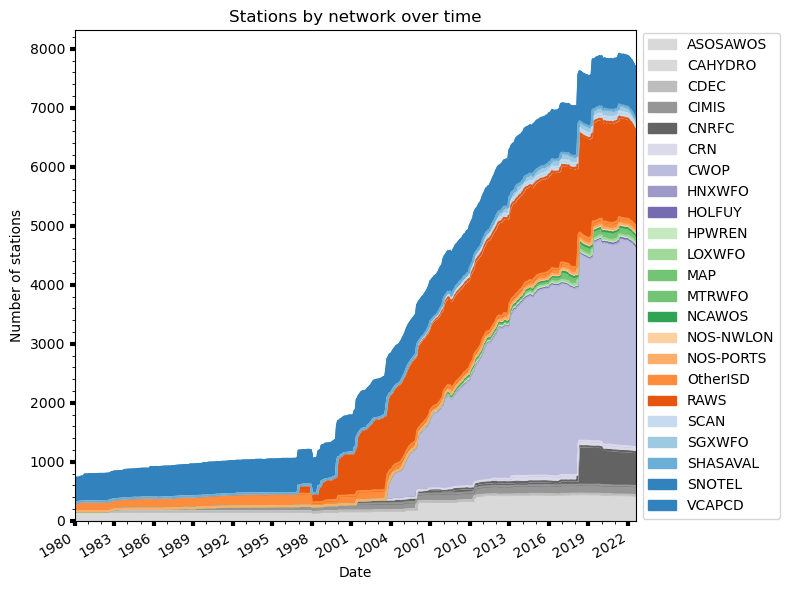

In [41]:
# Plot
outt = out.T.reset_index()

# Fix time component
outt['date'] = outt['period'].astype(str)
outt['date'] = pd.to_datetime(outt['date'])

# Plot parameters
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.rcParams['figure.facecolor'] = 'white'

# Subplot parameters
fig, ax = plt.subplots(figsize = (8, 6))
outt.plot.area(x = 'date', title = 'Stations by network over time', ax = ax, x_compat = True, cmap = 'tab20c_r') # Get area plot
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5)) # Fix legend 
ax.tick_params(labelcolor='black', labelsize='medium', width=3)
ax.set_facecolor('w')
ax.set_xlabel("Date")
ax.set_ylabel("Number of stations")

# Change axis bounds
ax.set_xlim([date(1980, 1, 1), date(2022, 8, 1)])

# Change tick marks
ax.minorticks_on()
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator(3))
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y"))
ax.xaxis.set_minor_locator(matplotlib.dates.YearLocator(1))

# Change y ticks
plt.locator_params(axis='y', nbins=12)
ax.yaxis.get_ticklocs(minor=True)

# Set x axis labels
# #plt.title("Stations Over Time By Network")
plt.subplots_adjust(left=0.2,bottom=0.2, top = 0.8, right = 0.8)

# Save to AWS
img_data = BytesIO()
plt.savefig(img_data, format='png')
img_data.seek(0)

s3 = boto3.resource('s3')
bucket = s3.Bucket(bucket_name)
bucket.put_object(Body=img_data, ContentType='image/png', Key="1_raw_wx/stations_over_time.png")

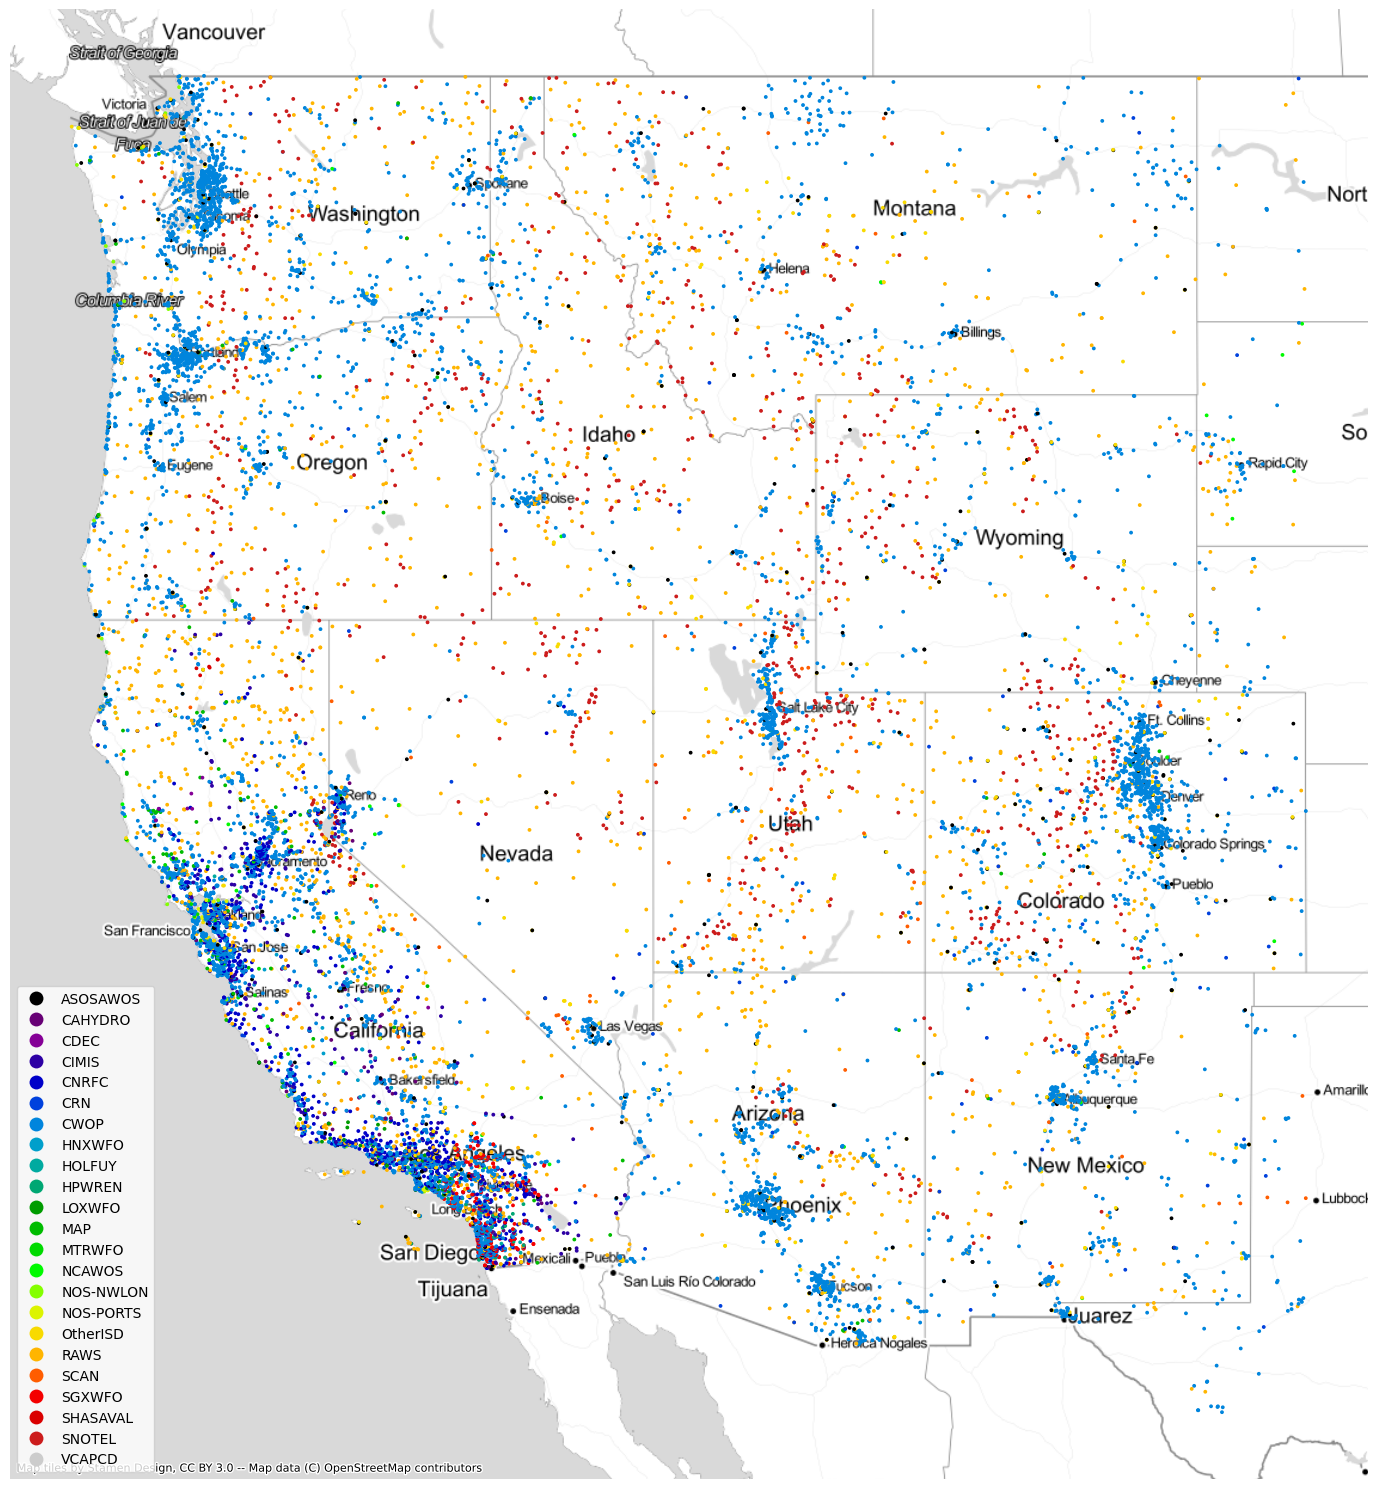

In [9]:
# Run function - generate station map

def get_station_map(bucket_name, directory, shapepath, update = False):
    s3 = boto3.resource("s3") 
    s3_cl = boto3.client('s3') # for lower-level processes
    if update == False:
        obj = s3_cl.get_object(Bucket = bucket_name, Key = "1_raw_wx/temp_master_station_list.csv")
        body = obj['Body'].read()
        dffull = pd.read_csv(BytesIO(body), encoding='utf8')
    elif update == True:
        dffull = get_station_list(bucket_name, directory)

    # Get period

    # Format dates in datetime format (this gets lost in import).
    dffull['start-date'] = pd.to_datetime(dffull['start-date'], utc = True)
    dffull['end-date'] = pd.to_datetime(dffull['end-date'], utc = True)

    # Quality control.
    # Fix nas
    ## Filter out rows w/o start date
    subdf = dffull.loc[~dffull['start-date'].isnull()].copy()
    # Filter out rows without data between 1980 and now.
    subdf = subdf.loc[(subdf['start-date']<=datetime.utcnow().replace(tzinfo=timezone.utc)) & (subdf['end-date']>='1980-01-01')]
    
    # Make a geodataframe.
    gdf = gpd.GeoDataFrame(subdf, geometry=gpd.points_from_xy(subdf.longitude, subdf.latitude))
    gdf.set_crs(epsg=4326, inplace=True) # Set CRS
    
    # Project data to match base tiles.
    gdf_wm = gdf.to_crs(epsg=3857) # Web mercator

    # Read in geometry of continental US.
    us = gpd.read_file(shapepath)

    # Remove territories, AK, HI
    rem_list = ["HI", "AK", "MP", "GU", "AS", "PR", "VI"]
    us = us.loc[us.STUSPS.isin(rem_list) == False]

    # Use to clip stations
    us = us.to_crs(epsg = 3857)
    gdf_us = gdf_wm.clip(us)

    
    # Version 1 - full map
    ax = gdf_us.plot("network", figsize=(15, 15), alpha=1, markersize = 3, legend = True, cmap = 'nipy_spectral')
    cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite)
    ax.set_axis_off()

    # Save to AWS
    img_data = BytesIO()
    plt.savefig(img_data, format='png')
    img_data.seek(0)

    s3 = boto3.resource('s3')
    bucket = s3.Bucket(bucket_name)
    bucket.put_object(Body=img_data, ContentType='image/png', Key="1_raw_wx/station_map.png")

    # Version 2    
    # If <100 stations, change to misc
    # Sort stations by number of networks
    #gdf_us['network_count'] = gdf_us.groupby('network')['network'].transform('count') # Add network count column.
    
    # gdf_us.loc[gdf_us['network_count'] < 100, 'network'] = "Misc"
    
    # # Plot
    # ax = gdf_us.plot("network", figsize=(15, 15), alpha=1, markersize = 3, legend = True, cmap = 'nipy_spectral')
    # cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite)
    # ax.set_axis_off()

    # Save to AWS
    # img_data = BytesIO()
    # plt.savefig(img_data, format='png')
    # img_data.seek(0)

    # s3 = boto3.resource('s3')
    # bucket = s3.Bucket(bucket_name)
    # bucket.put_object(Body=img_data, ContentType='image/png', Key="1_raw_wx/station_map_min.png")
        
shapepath = "s3://wecc-historical-wx/0_maps/tl_2021_us_state.shp"
get_station_map(bucket_name, directory, shapepath = shapepath, update = False)